In [73]:
from src.utils.analysis import LSTMEncodingAnalyzer

import numpy as np

In [74]:
PATH = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/f0_reconstruction/lstm_2023-05-23-08-31-55"

In [75]:
analyzer = LSTMEncodingAnalyzer(PATH)

all lengths 65686 65686 65686 65686


In [90]:
analyzer.predictions[0].shape, analyzer.targets[1].shape, analyzer.targets[
    0
].shape, analyzer.latents[0].shape

((155, 1), (155, 1), (155, 1), (155, 64))

In [76]:
analyzer.compute_mse(10)

0.08273346

### Plot reconstruction

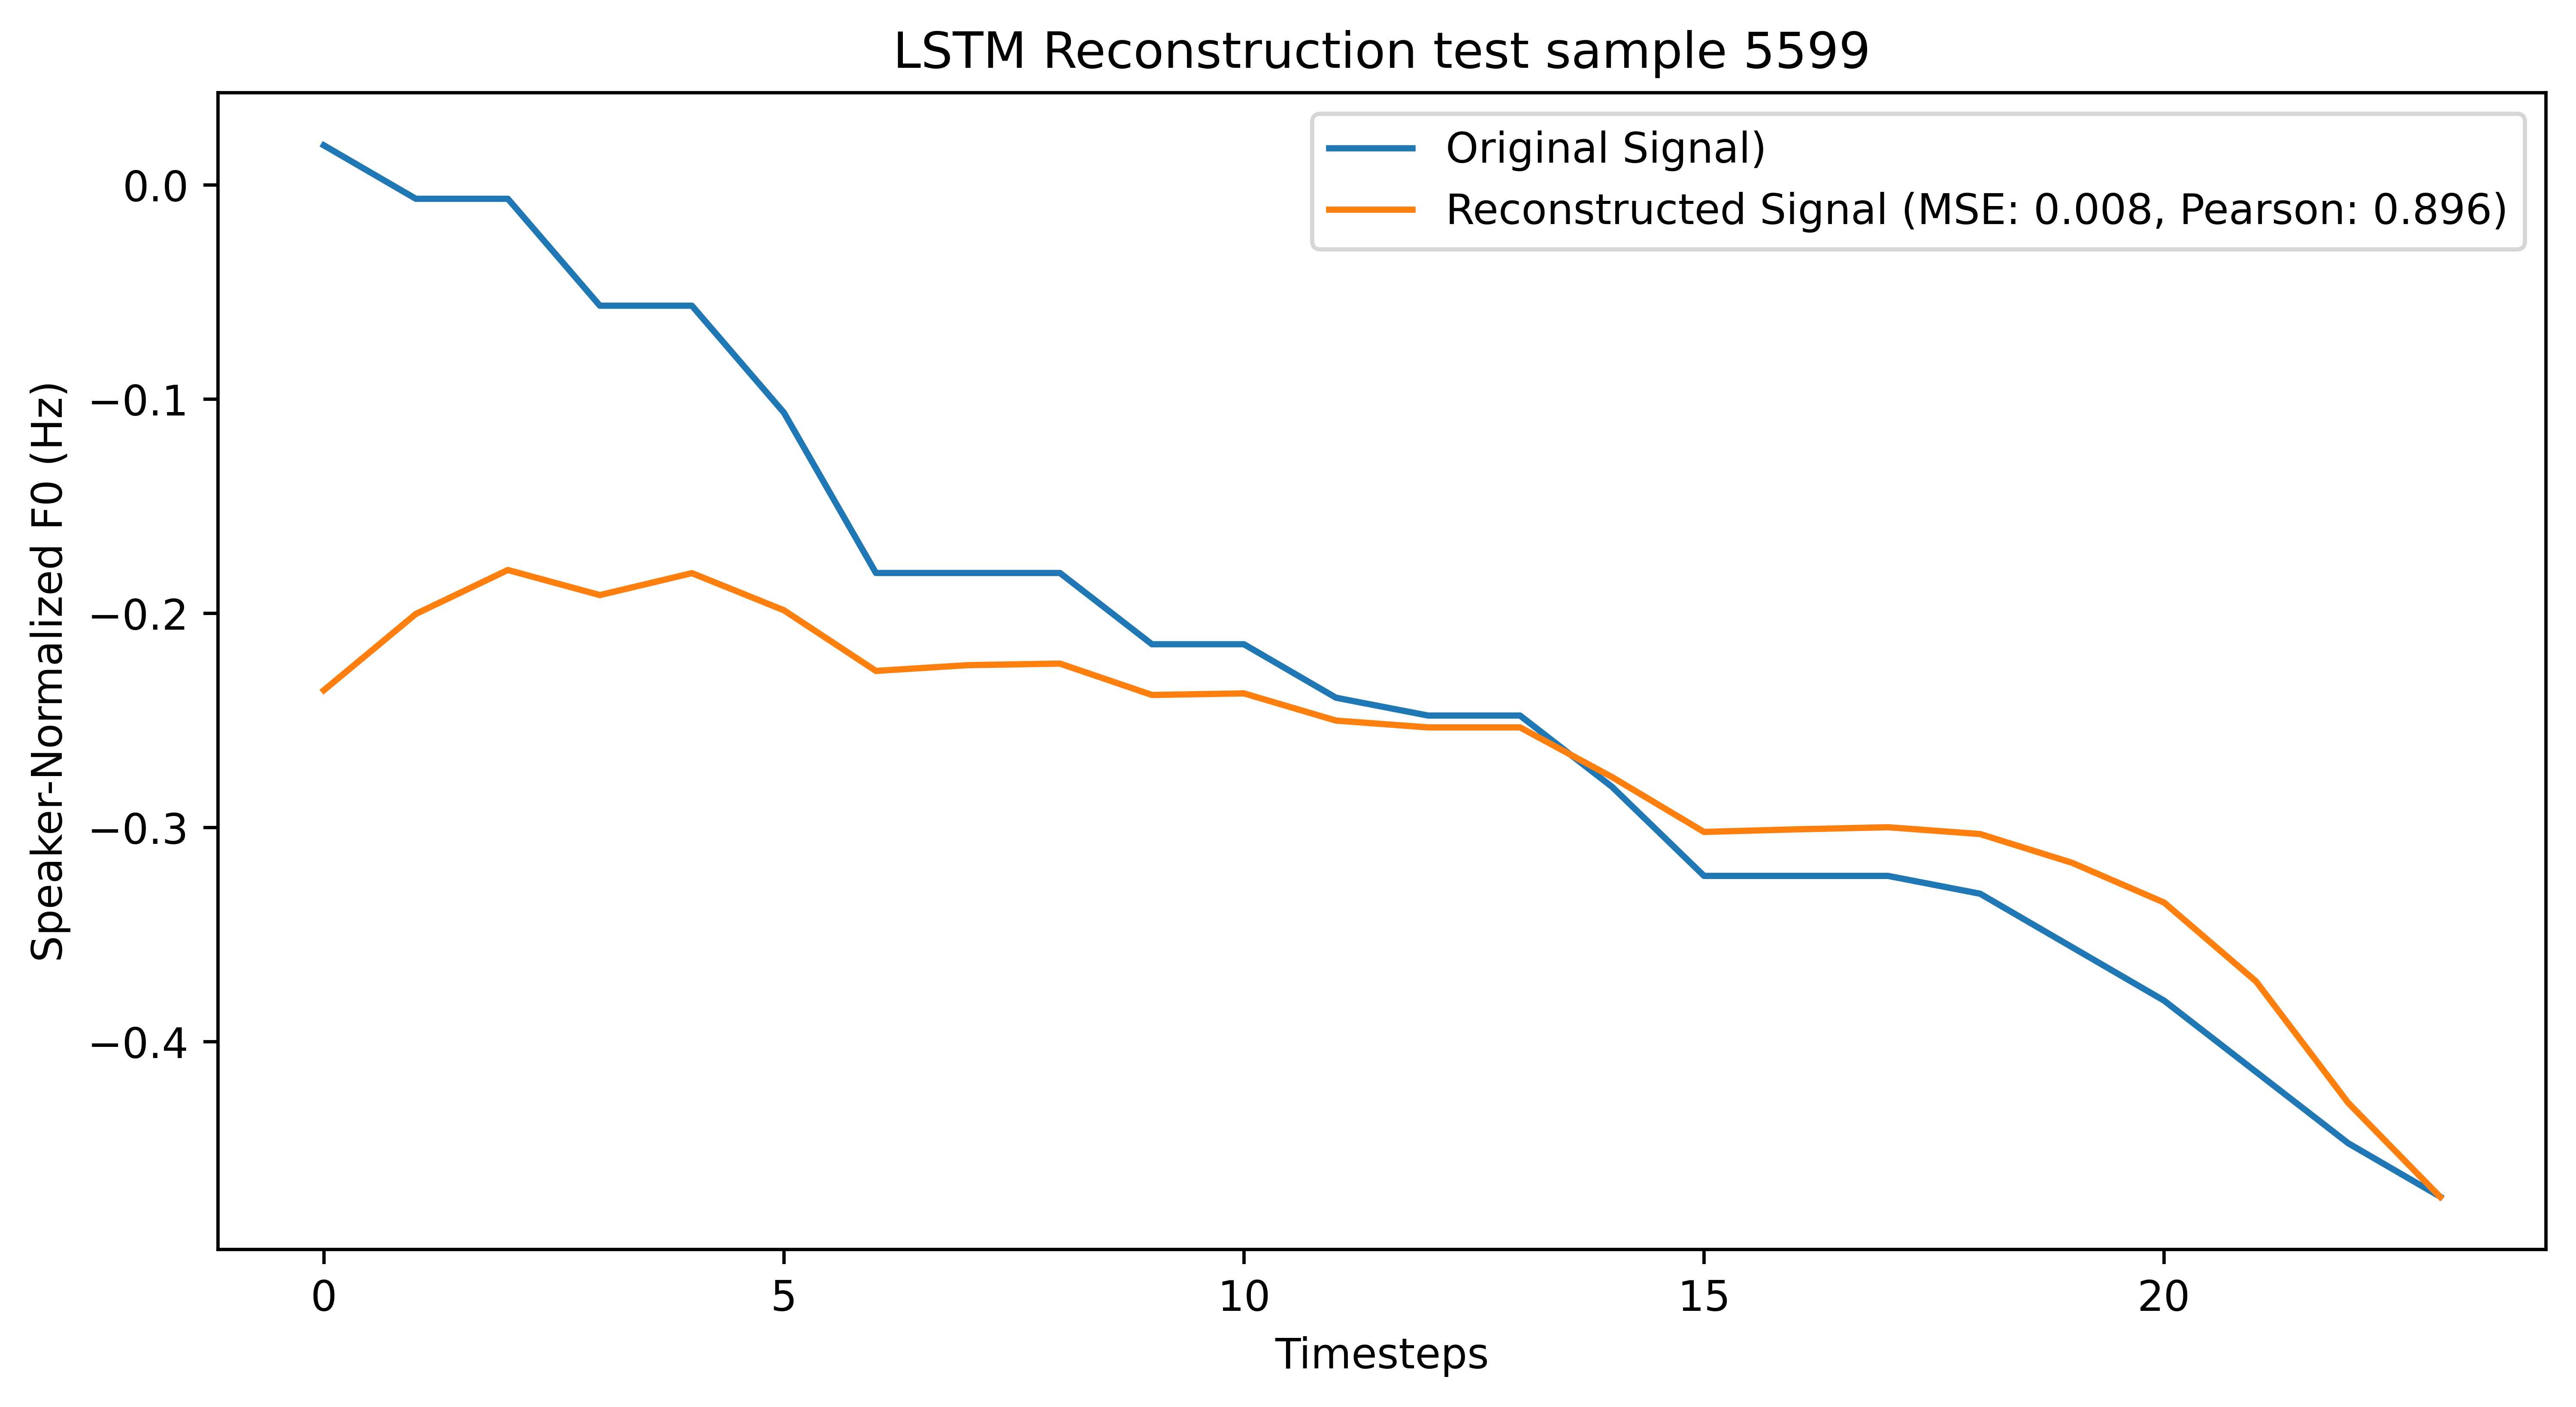

In [77]:
from src.utils.plots import plot_signals_with_mse_pearson

idx = 5599

mask = analyzer.get_loss_mask(idx).squeeze()
target = analyzer.get_target(idx).squeeze()[mask == 1]
prediction = analyzer.get_prediction(idx).squeeze()[mask == 1]


plot_signals_with_mse_pearson(
    target,
    prediction,
    title=f"LSTM Reconstruction test sample {idx}",
    xlabel="Timesteps",
    ylabel="Speaker-Normalized F0 (Hz)",
)

## Analyze latent space 

In [85]:
all_latents = analyzer.latents
all_targets = analyzer.targets
all_masks = analyzer.loss_masks
all_predictions = analyzer.predictions

In [79]:
len(all_targets)

65686

In [80]:
len(all_latents)

65686

In [81]:
len(all_masks)

65686

In [82]:
all_latents[0].shape

(155, 64)

In [83]:
all_masks[0].shape

(155, 1)

In [91]:
import torch
from torch import nn

In [95]:
rnn = nn.LSTM(10, 20, 2)  # input_size, hidden_size, num_layers
input = torch.randn(5, 3, 10)  # seq_len, batch, input_size
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]), torch.Size([2, 3, 20]))

### LSTM Test

In [5]:
import torch
from torch import nn


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # concatenate the hidden states from the forward and backward pass
        hidden = torch.cat(
            (hidden[0 : hidden.size(0) : 2], hidden[1 : hidden.size(0) : 2]), 2
        )
        cell = torch.cat((cell[0 : cell.size(0) : 2], cell[1 : cell.size(0) : 2]), 2)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        output = self.fc(output)
        return output, (hidden, cell)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, teacher_forcing_ratio=0.5):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, source, target=None, debug=False):
        batch_size = source.size(0)
        seq_length = source.size(1)

        # Encoding
        hidden, cell = self.encoder(source)
        if debug:
            print(f"hidden shape {hidden.shape}, cell shape {cell.shape}")

        # Prepare space for the output of the decoder
        outputs = torch.zeros(batch_size, seq_length, 1).to(source.device)

        # Use last value of the input sequence as initial input for the decoder
        decoder_input = torch.zeros(batch_size, 1, 1).to(source.device)
        if debug:
            print(f"decoder input shape {decoder_input.shape}")

        # Decoding
        for t in range(seq_length):
            output, (hidden, cell) = self.decoder(decoder_input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)

            # Decide whether to use teacher forcing
            teacher_force = (
                target is not None and random.random() < self.teacher_forcing_ratio
            )
            # If teacher forcing, use actual target as the next input. If not, use predicted output.
            decoder_input = target[:, t, :].unsqueeze(1) if teacher_force else output

        return outputs

Epoch 10/100, Loss: 0.49907222390174866
Epoch 20/100, Loss: 0.49700453877449036
Epoch 30/100, Loss: 0.49173739552497864
Epoch 40/100, Loss: 0.47375792264938354
Epoch 50/100, Loss: 0.44552332162857056
Epoch 60/100, Loss: 0.29889801144599915
Epoch 70/100, Loss: 0.057373519986867905
Epoch 80/100, Loss: 0.032480139285326004
Epoch 90/100, Loss: 0.012029118835926056
Epoch 100/100, Loss: 0.006215908098965883
Input sequence offset: [[5.89629353]]
Output sequence offset: -0.39597120705390737


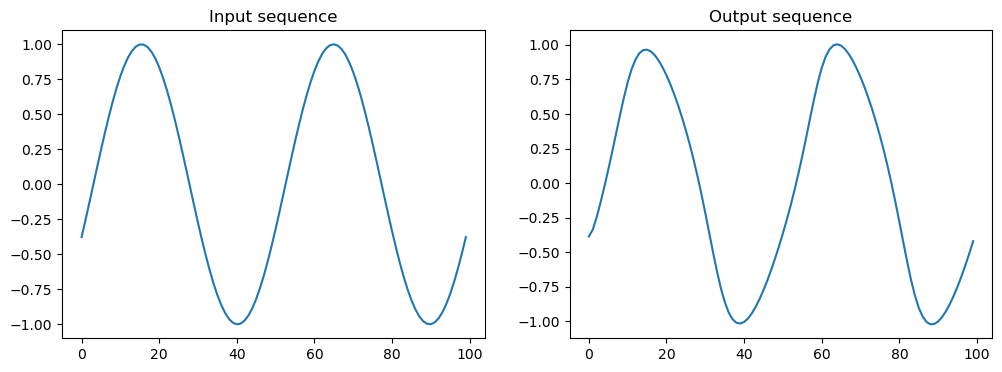

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
input_size = 1
hidden_size = (
    32  # since the LSTM is bidirectional, the actual hidden size will be double this
)
output_size = 1
num_epochs = 100
seq_length = 100
num_samples = 1000
learning_rate = 0.001

# Generate sine wave data with random offsets
offsets = np.random.rand(num_samples, 1) * 2 * np.pi
x = np.sin(np.linspace(0, 4 * np.pi, seq_length)[None, :] + offsets)
x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
y = x.clone()  # target is same as input

# Initialize the model, loss function, and optimizer
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(input_size, hidden_size * 2, output_size)
model = Seq2Seq(encoder, decoder)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    model.train()
    output = model(x)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Testing
model.eval()
offset = np.random.rand(1, 1) * 2 * np.pi
x_test = np.sin(np.linspace(0, 4 * np.pi, seq_length)[None, :] + offset)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1)
output = model(x_test)

print(f"Input sequence offset: {offset}")
print(f"Output sequence offset: {np.arcsin(output[0, 0, 0].item())}")

# Plot input and output
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_test[0].numpy())
plt.title("Input sequence")
plt.subplot(1, 2, 2)
plt.plot(output[0].detach().numpy())
plt.title("Output sequence")
plt.show()